In [19]:
from pathlib import Path
import sys

sys.path.append(str(Path.cwd() / "sourcecode"))
from RC_Optimization import build_tariff, optimize_hhp_operation, plot_hhp_results_components


REPO_ROOT = Path.cwd()
SOURCE_DIR = REPO_ROOT / 'sourcecode'
DATA_DIR = REPO_ROOT  / 'Data'
OUTPUT_DIR = REPO_ROOT / 'Output' / 'DemandProfiles'

if str(SOURCE_DIR) not in sys.path:
    sys.path.append(str(SOURCE_DIR))

print(f'Repository root: {REPO_ROOT}')
print(f'Source directory: {SOURCE_DIR}')
print(f'Data directory: {DATA_DIR}')
print(f'Output directory: {OUTPUT_DIR}')

Repository root: E:\GitHubProjects\LV network\Codes
Source directory: E:\GitHubProjects\LV network\Codes\sourcecode
Data directory: E:\GitHubProjects\LV network\Codes\Data
Output directory: E:\GitHubProjects\LV network\Codes\Output\DemandProfiles


In [20]:
import pandas as pd

import generate_demand_profiles as gdp

summary_path = DATA_DIR / '1R1C1P1S_filtered_filtered.csv'
weather_path = DATA_DIR / 'EOH2303_merged_30min.csv'
start = pd.Timestamp('2022-02-09 00:00')
end = pd.Timestamp('2022-02-13 23:30')

params = gdp.load_summary(summary_path)
weather = gdp.load_weather(weather_path, start, end)



weather['External_Air_Temperature'] = weather['External_Air_Temperature']-5
# -5 celsius to create an extreme weather case 
len(params), weather.head()

(508,
                      Unnamed: 0  Circulation_Pump_Energy_Consumed  \
 time                                                                
 2022-02-09 00:00:00       11978                               0.0   
 2022-02-09 00:30:00       11979                               0.0   
 2022-02-09 01:00:00       11980                               0.0   
 2022-02-09 01:30:00       11981                               0.0   
 2022-02-09 02:00:00       11982                               0.0   
 
                      Heat_Pump_Energy_Output  Whole_System_Energy_Consumed  \
 time                                                                         
 2022-02-09 00:00:00                      0.0                         0.005   
 2022-02-09 00:30:00                      0.0                         0.005   
 2022-02-09 01:00:00                      0.0                         0.004   
 2022-02-09 01:30:00                      0.0                         0.005   
 2022-02-09 02:00:00        

In [25]:
dt_seconds = weather.index.to_series().diff().dropna().median().total_seconds()

tariff_days = int((end.normalize() - start.normalize()).days) + 1
tariff = gdp.build_tariff(start.normalize(), n_days=tariff_days, step='30min', type='flat')
tariff = gdp.ensure_aligned_tariff(tariff, weather.index)

setpoint = gdp.derive_setpoint(weather.index)

print(setpoint)
# initial_temperature = gdp.derive_initial_temperature(weather)
initial_temperature = 21.0
comfort_tolerance = 1.0  # °C
heat_pump_cop = 3.5
boiler_efficiency = 0.9

min_hp_capacity_kw = 4.0
hp_capacity_step_kw = 0.5
max_hp_capacity_kw = 4.0

min_hp_capacity_w = min_hp_capacity_kw * 1000.0
hp_capacity_step_w = hp_capacity_step_kw * 1000.0
max_hp_capacity_w = max_hp_capacity_kw * 1000.0
boiler_capacity_w = 24_000.0

dt_seconds, initial_temperature

[18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 21. 21. 21. 21. 21. 21.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 21. 21.
 21. 21. 21. 21. 21. 21. 21. 21. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.
 18. 18. 18. 18. 18. 18. 21. 21. 21. 21. 21. 21. 18. 18. 18. 18. 18. 18.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 21. 21. 21. 21. 21. 21. 21. 21.
 21. 21. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.
 21. 21. 21. 21. 21. 21. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.
 18. 18. 18. 18. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 18. 18. 18. 18.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 21. 21. 21. 21. 21. 21.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 21. 21.
 21. 21. 21. 21. 21. 21. 21. 21. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.
 18. 18. 18. 18. 18. 18. 21. 21. 21. 21. 21. 21. 18. 18. 18. 18. 18. 18.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 21. 21. 21. 21. 21. 21. 21. 21.
 21. 21. 18. 18. 18. 18.]


(1800.0, 21.0)

In [26]:
from collections import OrderedDict

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
optimisation_results = OrderedDict()

Tout = gdp.extract_outdoor_temperature(weather)
solar_gain = gdp.extract_solar_gain(weather, dt_seconds)

for param in params:
    hp_capacity_w = min_hp_capacity_w
    
    while True:
        try:
            result = gdp.optimize_hhp_operation(
                param.R1,
                param.C1,
                param.g,
                tariff,
                Tout,
                solar_gain,
                dt_seconds,
                initial_temperature,
                T_setpoint=setpoint,
                tol=comfort_tolerance,
                COP=heat_pump_cop,
                etaB=boiler_efficiency,
                Qhp_max=hp_capacity_w,
                Qbo_max=boiler_capacity_w,
                day_ahead=False,
            )
        except RuntimeError as exc:
            message = str(exc).lower()
            if 'gurobi failed on subproblem' not in message or 'status 3' not in message:
                raise
            if hp_capacity_w + hp_capacity_step_w > max_hp_capacity_w:
                raise RuntimeError(
                    f"Failed to find feasible HP capacity for {param.dwelling_id} up to {max_hp_capacity_kw:.1f} kW"
                ) from exc
            hp_capacity_w += hp_capacity_step_w
            print(
                f"{param.dwelling_id}: increasing heat pump capacity to {hp_capacity_w / 1000:.1f} kW after solver failure"
            )
            continue
        else:
            break

    result = result.copy()
    result['total_heat_W'] = result['Q_hp'] + result['Q_bo']
    result['total_heat_kW'] = result['total_heat_W'] / 1000.0
    hp_capacity_kw = hp_capacity_w / 1000.0
    result['hp_capacity_kW'] = hp_capacity_kw

    out_path = OUTPUT_DIR / f"{param.dwelling_id}_Feb09-13_2022_{hp_capacity_kw:.1f}kW.csv"
    result.to_csv(out_path, index_label='time')
    optimisation_results[param.dwelling_id] = result
    print(
        f"Saved demand profile for {param.dwelling_id} -> {out_path} (HP capacity {hp_capacity_kw:.1f} kW)"
    )

len(optimisation_results)

Saved demand profile for EOH0003 -> E:\GitHubProjects\LV network\Codes\Output\DemandProfiles\EOH0003_Feb09-13_2022_4.0kW.csv (HP capacity 4.0 kW)
Saved demand profile for EOH0014 -> E:\GitHubProjects\LV network\Codes\Output\DemandProfiles\EOH0014_Feb09-13_2022_4.0kW.csv (HP capacity 4.0 kW)
Saved demand profile for EOH0018 -> E:\GitHubProjects\LV network\Codes\Output\DemandProfiles\EOH0018_Feb09-13_2022_4.0kW.csv (HP capacity 4.0 kW)
Saved demand profile for EOH0021 -> E:\GitHubProjects\LV network\Codes\Output\DemandProfiles\EOH0021_Feb09-13_2022_4.0kW.csv (HP capacity 4.0 kW)
Saved demand profile for EOH0025 -> E:\GitHubProjects\LV network\Codes\Output\DemandProfiles\EOH0025_Feb09-13_2022_4.0kW.csv (HP capacity 4.0 kW)
Saved demand profile for EOH0026 -> E:\GitHubProjects\LV network\Codes\Output\DemandProfiles\EOH0026_Feb09-13_2022_4.0kW.csv (HP capacity 4.0 kW)
Saved demand profile for EOH0027 -> E:\GitHubProjects\LV network\Codes\Output\DemandProfiles\EOH0027_Feb09-13_2022_4.0kW.csv

508

In [ ]:
sample_dwelling = next(iter(optimisation_results))
print(sample_dwelling)

In [50]:
sample_dwelling = "EOH0038"
sample_result = optimisation_results[sample_dwelling]
sample_result.tail()

,Q_hp,Q_bo,Tin,T_set,T_low,T_high,total_heat_W,total_heat_kW,hp_capacity_kW
time,,,,,,,,,
2022-02-13 21:30:00,0.0,0.0,20.000000,21.0,20.0,22.0,0.0,0.0,23.0
2022-02-13 22:00:00,0.0,0.0,19.980778,18.0,15.0,NaN,0.0,0.0,23.0
2022-02-13 22:30:00,0.0,0.0,19.961567,18.0,15.0,NaN,0.0,0.0,23.0
2022-02-13 23:00:00,0.0,0.0,19.942369,18.0,15.0,NaN,0.0,0.0,23.0
2022-02-13 23:30:00,0.0,0.0,19.923194,18.0,15.0,NaN,0.0,0.0,23.0


In [23]:
available_result_files = sorted(OUTPUT_DIR.glob('*.csv'))
if available_result_files:
    print('Saved result files:')
    for path in available_result_files:
        print(f' - {path.name}')
else:
    print(f'No saved result files found in {OUTPUT_DIR}')

selected_result_filename = "mHP_Flat_Extreme\\EOH0018_Feb09-13_2022_7.0kW.csv"  # e.g. 'Dwelling_Feb09-13_2022_7.0kW.csv'
if selected_result_filename:
    selected_result_path = OUTPUT_DIR / selected_result_filename
    if not selected_result_path.exists():
        raise FileNotFoundError(f'Could not find {selected_result_path}')
    sample_result = pd.read_csv(selected_result_path, index_col='time', parse_dates=True)
    sample_dwelling = selected_result_path.stem
    print(f'Reloaded {selected_result_filename} for plotting.')
else:
    print('Using in-memory sample_result; update selected_result_filename to reload from disk if needed.')

No saved result files found in E:\GitHubProjects\LV network\Codes\Output\DemandProfiles
Reloaded mHP_Flat_Extreme\EOH0018_Feb09-13_2022_7.0kW.csv for plotting.


Figure saved to E:\GitHubProjects\LV network\Codes\Output\DemandProfiles\figures\EOH0018_Feb09-13_2022_7.0kW_dispatch.png
time
2022-02-09 00:00:00    1.761333
2022-02-09 00:30:00    1.806667
2022-02-09 01:00:00    1.860000
2022-02-09 01:30:00    1.926000
2022-02-09 02:00:00    1.836000
                         ...   
2022-02-13 21:30:00   -0.139333
2022-02-13 22:00:00   -0.150000
2022-02-13 22:30:00   -0.159333
2022-02-13 23:00:00   -0.160000
2022-02-13 23:30:00   -0.160000
Name: External_Air_Temperature, Length: 240, dtype: float64


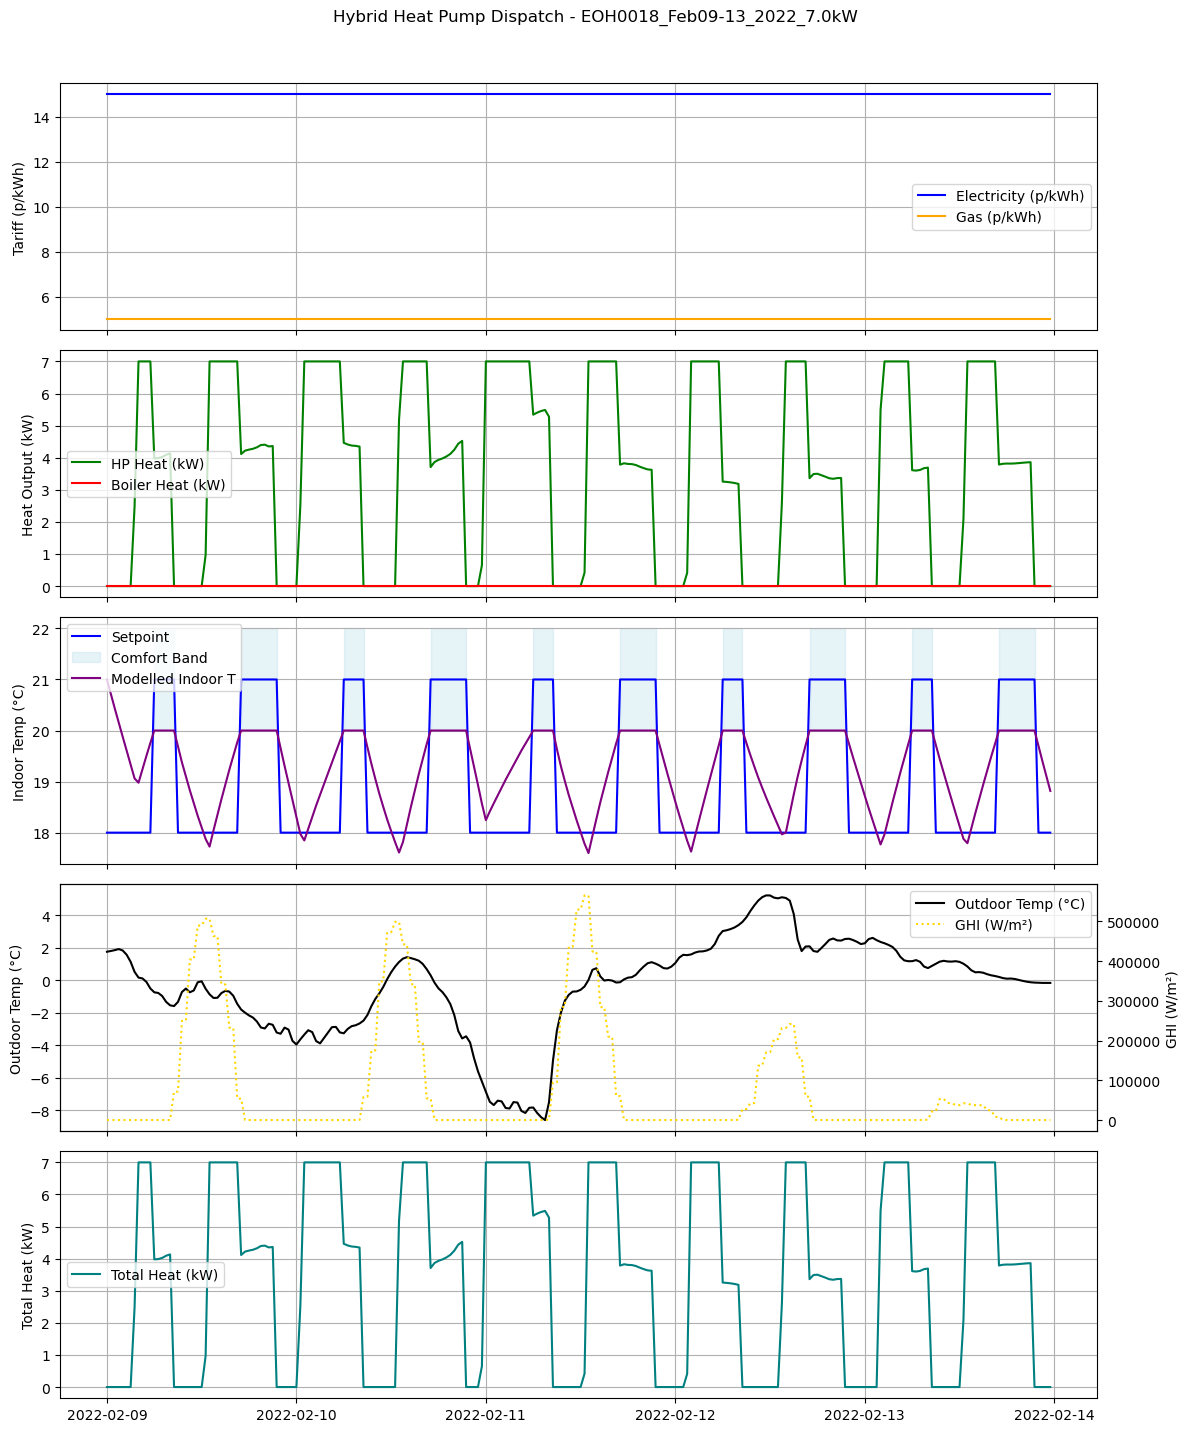

In [24]:
plot_weather = weather.copy()

if '' in plot_weather.columns:
    plot_weather = plot_weather.drop(columns=[''])

if 'External_Air_Temperature' not in plot_weather.columns:
    tout_series = pd.Series(Tout, index=weather.index, name='External_Air_Temperature')
    plot_weather = plot_weather.assign(External_Air_Temperature=tout_series)

if 'GHI' not in plot_weather.columns and 'ssrd_J_m2_30min' in plot_weather.columns:
    plot_weather = plot_weather.rename(columns={'ssrd_J_m2_30min': 'GHI'})

plot_output_dir = OUTPUT_DIR / 'figures'
plot_output_dir.mkdir(parents=True, exist_ok=True)

plot_hhp_results_components(
    Tin=sample_result['Tin'].to_numpy(),
    Q_hp=sample_result['Q_hp'].to_numpy(),
    Q_bo=sample_result['Q_bo'].to_numpy(),
    T_set=sample_result['T_set'].to_numpy(),
    T_low=sample_result['T_low'].to_numpy(),
    T_high=sample_result['T_high'].to_numpy(),
    index=sample_result.index,
    tariff=tariff,
    df=plot_weather,
    title_prefix=f"Hybrid Heat Pump Dispatch - {sample_dwelling}",
    save_dir=str(plot_output_dir),
    filename=f"{sample_dwelling}_dispatch.png",
)

print(plot_weather["External_Air_Temperature"])